In [90]:
# add folders to Python's search space
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
print(module_dir)

# import the rest of the modules
%matplotlib nbagg
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import arch
import pandas as pd
from scipy.signal import savgol_filter
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.transforms as mtrans
import dom
import matplotlib.cm as cm
from matplotlib.colors import Normalize
DTYPE = 'float32'

C:\Users\pinak\Documents\GitHub\var-al


In [67]:
# load learned solutions
net_p = arch.LSTMForgetNet(50, 3, DTYPE, dim=3, name="Beltrami")
net_p.load_weights('../data/Beltrami/{}'.format(net_p.name)).expect_partial()

net_al = arch.LSTMForgetNet(50, 3, DTYPE, dim=3, name='Beltrami-al')
net_al.load_weights('../data/Beltrami-al/{}'.format(net_al.name)).expect_partial()

def true(x, y, z):
    p = tf.sin(z) + tf.cos(y)
    q = tf.sin(x) + tf.cos(z)
    r = tf.sin(y) + tf.cos(x)
    return tf.concat([p, q, r], axis=-1)

def curl(f, x, y, z):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y, z])
        Ax, Ay, Az = tf.split(f(x, y, z), 3, axis=-1)
    Ax_y = tape.gradient(Ax, y)
    Ay_x = tape.gradient(Ay, x)
    Ax_z = tape.gradient(Ax, z)
    Az_x = tape.gradient(Az, x)
    Ay_z = tape.gradient(Ay, z)
    Az_y = tape.gradient(Az, y)
    return tf.concat([(Az_y - Ay_z), (Ax_z - Az_x), (Ay_x - Ax_y)], axis=-1) 



class Cube:
    def __init__(self, center=np.zeros(3), a=1., b=1., c=1., dtype='float32'):
        self.a = a
        self.b = b 
        self.c = c
        self.center = center
        self.n_bdry_comps = 6
        self.dtype = dtype

    def grid_sample(self, resolution):
        x = np.linspace(start=-self.a/2., stop=self.a/2., num=resolution, endpoint=False, dtype=self.dtype)
        y = np.linspace(start=-self.b/2., stop=self.b/2., num=resolution, endpoint=False, dtype=self.dtype)
        z = np.linspace(start=-self.c/2., stop=self.c/2., num=resolution, endpoint=False, dtype=self.dtype)
        x, y, z = np.meshgrid(x, y, z)
        x, y, z = x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1) 
        return self.center[0] + x, self.center[1] + y, self.center[2] + z

<IPython.core.display.Javascript object>


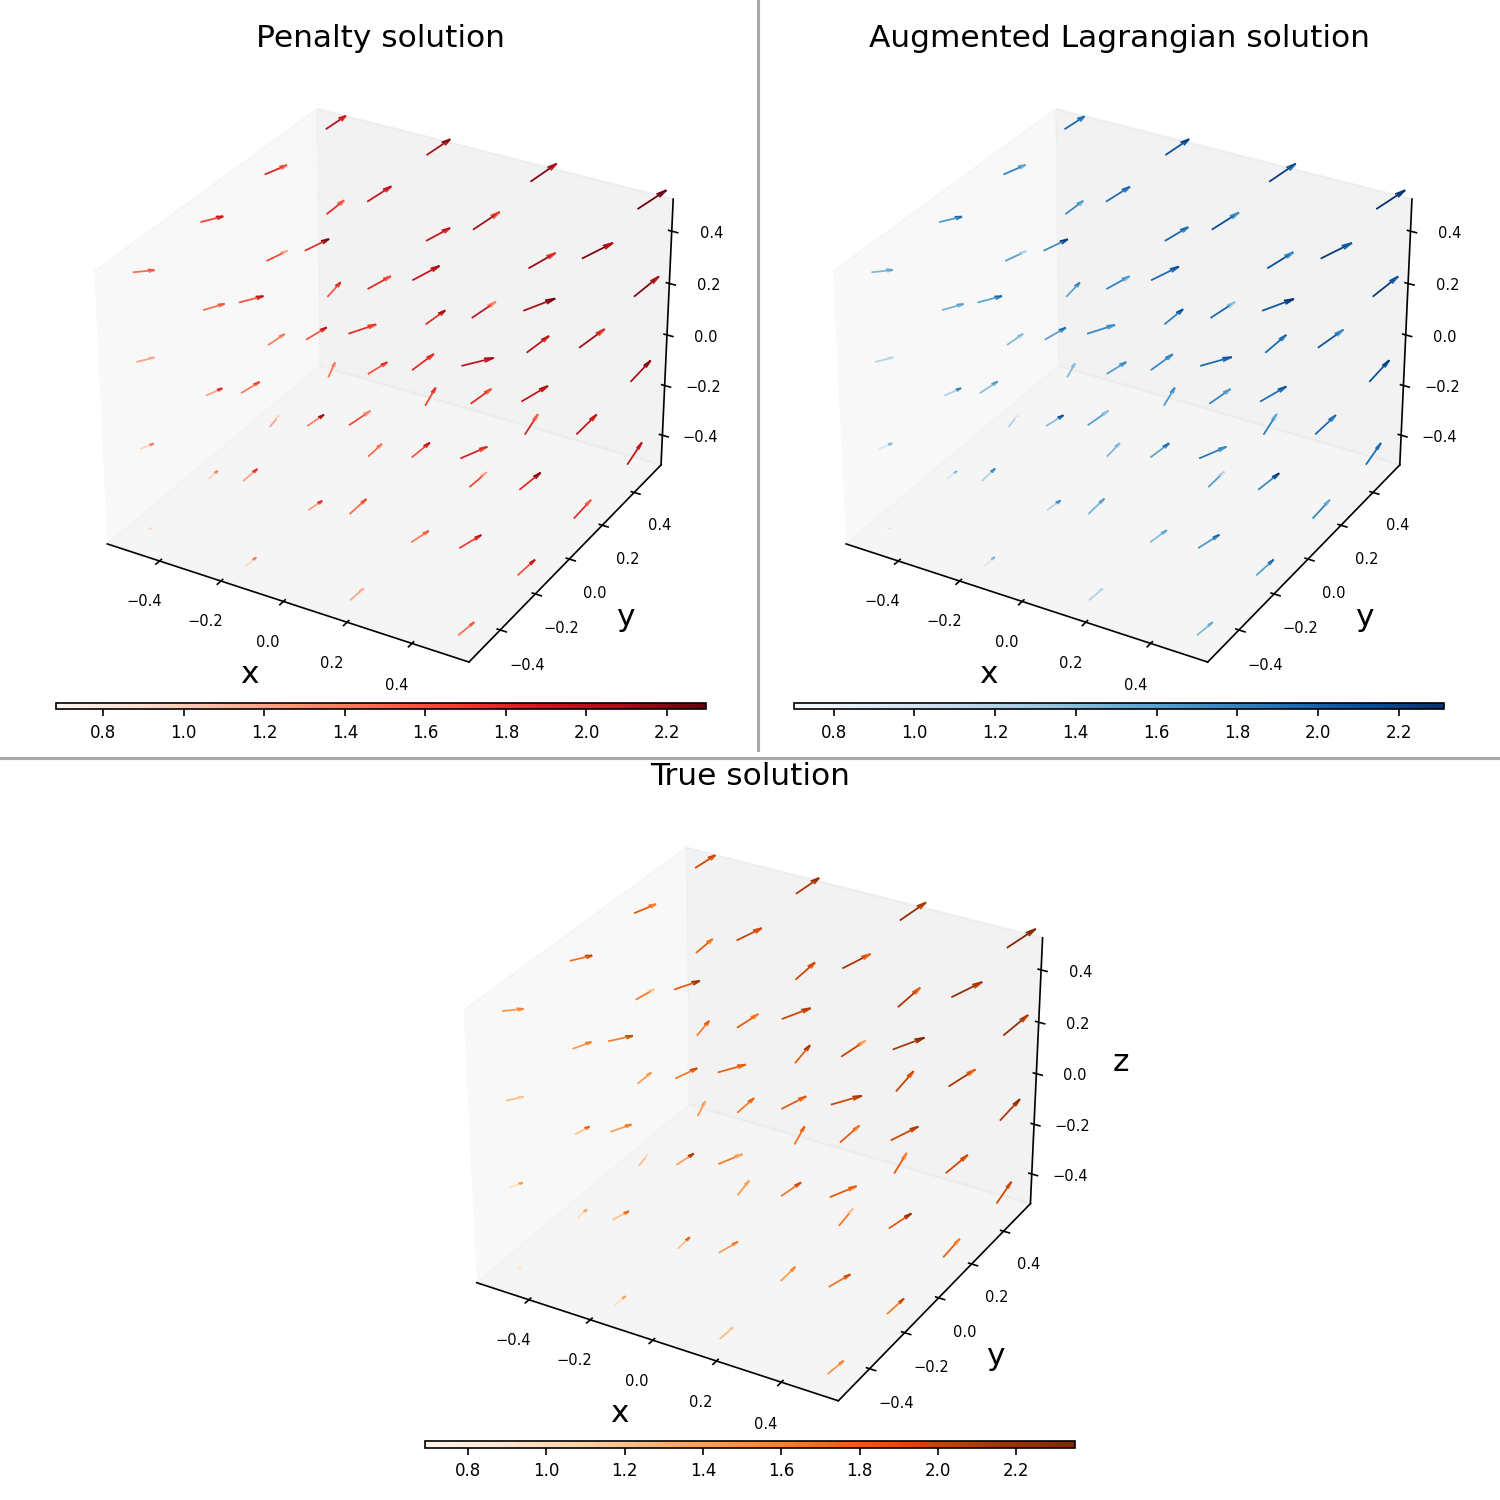

In [108]:
# set up plotting parameters
scale = 0
xlabel_size = ylabel_size = 15 + scale
tick_size = 7 + scale
legend_size = 15 + scale
title_size = 15 + scale
cbar_tick_size = 10 + scale
line_color = "darkgrey"

# plot solutions
def plot_solutions(filename, resolution=4):
    box = dom.Box3D(dtype=DTYPE)
    
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(2, 4, figure=fig)
    ax_p = fig.add_subplot(gs[0,:-2], projection='3d')
    ax_al = fig.add_subplot(gs[0,2:], projection='3d')
    ax_t = fig.add_subplot(gs[1,1:-1], projection='3d')
    # plotting params  
    ax_p.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_p.tick_params(axis='both', which='minor', labelsize=tick_size)
    ax_p.set_title('Penalty solution', fontsize=title_size)
    ax_p.set_xlabel('x', fontsize=xlabel_size)
    ax_p.set_ylabel('y', fontsize=ylabel_size)
    
    ax_al.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_al.tick_params(axis='both', which='minor', labelsize=tick_size)
    ax_al.set_title('Augmented Lagrangian solution', fontsize=title_size)
    ax_al.set_xlabel('x', fontsize=xlabel_size)
    ax_al.set_ylabel('y', fontsize=ylabel_size)

    ax_t.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_t.tick_params(axis='both', which='minor', labelsize=tick_size)
    ax_t.set_title('True solution', fontsize=title_size)
    ax_t.set_xlabel('x', fontsize=xlabel_size)
    ax_t.set_ylabel('y', fontsize=ylabel_size)
    ax_t.set_zlabel('z', fontsize=ylabel_size)
    
    grid3 = (resolution, resolution, resolution)
    grid2 = (resolution, resolution)
    
    
    x, y, z = box.grid_sample(resolution)
    xt, xf = tf.convert_to_tensor(x.reshape(-1, 1), dtype=DTYPE), x.flatten()
    yt, yf = tf.convert_to_tensor(y.reshape(-1, 1), dtype=DTYPE), y.flatten()
    zt, zf = tf.convert_to_tensor(z.reshape(-1, 1), dtype=DTYPE), z.flatten()
    l, lw = 0.1, .85
    
    Bx, By, Bz = tf.split(curl(net_p, xt, yt, zt), 3, axis=-1)
    p, q, r = Bx.numpy().flatten(), By.numpy().flatten(), Bz.numpy().flatten()
    c = np.sqrt(p*p + q*q + r*r)
    R = max(c)
    p, q, r = p/R, q/R, r/R
    norm = Normalize()
    norm.autoscale(c)
    colormap = cm.Reds
    colors = colormap(norm(c))
    im = ax_p.quiver(xf, yf, zf, p, q, r, colors = colors, length=l, lw=lw)
    sm = matplotlib.cm.ScalarMappable(cmap=colormap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax_p, orientation='horizontal', aspect=100, fraction=0.01, pad=0.00)
    cbar.ax.tick_params(labelsize=cbar_tick_size-2)
    ax_p.grid(False)

  
    Bx, By, Bz = tf.split(curl(net_al, xt, yt, zt), 3, axis=-1)
    p, q, r = Bx.numpy().flatten(), By.numpy().flatten(), Bz.numpy().flatten()
    c = np.sqrt(p*p + q*q + r*r)
    R = max(c)
    p, q, r = p/R, q/R, r/R
    norm = Normalize()
    norm.autoscale(c)
    colormap = cm.Blues
    colors = colormap(norm(c))
    im = ax_al.quiver(xf, yf, zf, p, q, r, colors = colors, length=l, lw=lw)
    sm = matplotlib.cm.ScalarMappable(cmap=colormap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax_al, orientation='horizontal', aspect=100, fraction=0.01, pad=0.00)
    cbar.ax.tick_params(labelsize=cbar_tick_size-2)
    ax_al.grid(False)
    
    Bx, By, Bz = tf.split(curl(true, xt, yt, zt), 3, axis=-1)
    p, q, r = Bx.numpy().flatten(), By.numpy().flatten(), Bz.numpy().flatten()
    c = np.sqrt(p*p + q*q + r*r)
    R = max(c)
    p, q, r = p/R, q/R, r/R
    norm = Normalize()
    norm.autoscale(c)
    colormap = cm.Oranges
    colors = colormap(norm(c))
    im = ax_t.quiver(xf, yf, zf, p, q, r, colors = colors, length=l, lw=lw)
    sm = matplotlib.cm.ScalarMappable(cmap=colormap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax_t, orientation='horizontal', aspect=100, fraction=0.01, pad=0.00)
    cbar.ax.tick_params(labelsize=cbar_tick_size-2)
    ax_t.grid(False)
    
    # plot and save
    fig.subplots_adjust(wspace=0., hspace=0.2)
#     Get the bounding boxes of the axes including text decorations
    l = 0.46
    line = plt.Line2D([l+.045,l+.045],[0.5,1], transform=fig.transFigure, color=line_color)
    fig.add_artist(line)
    l = 0.45
    line = plt.Line2D([0.0,1],[l+.045,l+.045], transform=fig.transFigure, color=line_color)
    fig.add_artist(line)
    fig.tight_layout()
    plt.savefig('{}.png'.format(filename), dpi=300)
    plt.show()

plot_solutions(filename='../plots/Beltrami-field')

<IPython.core.display.Javascript object>


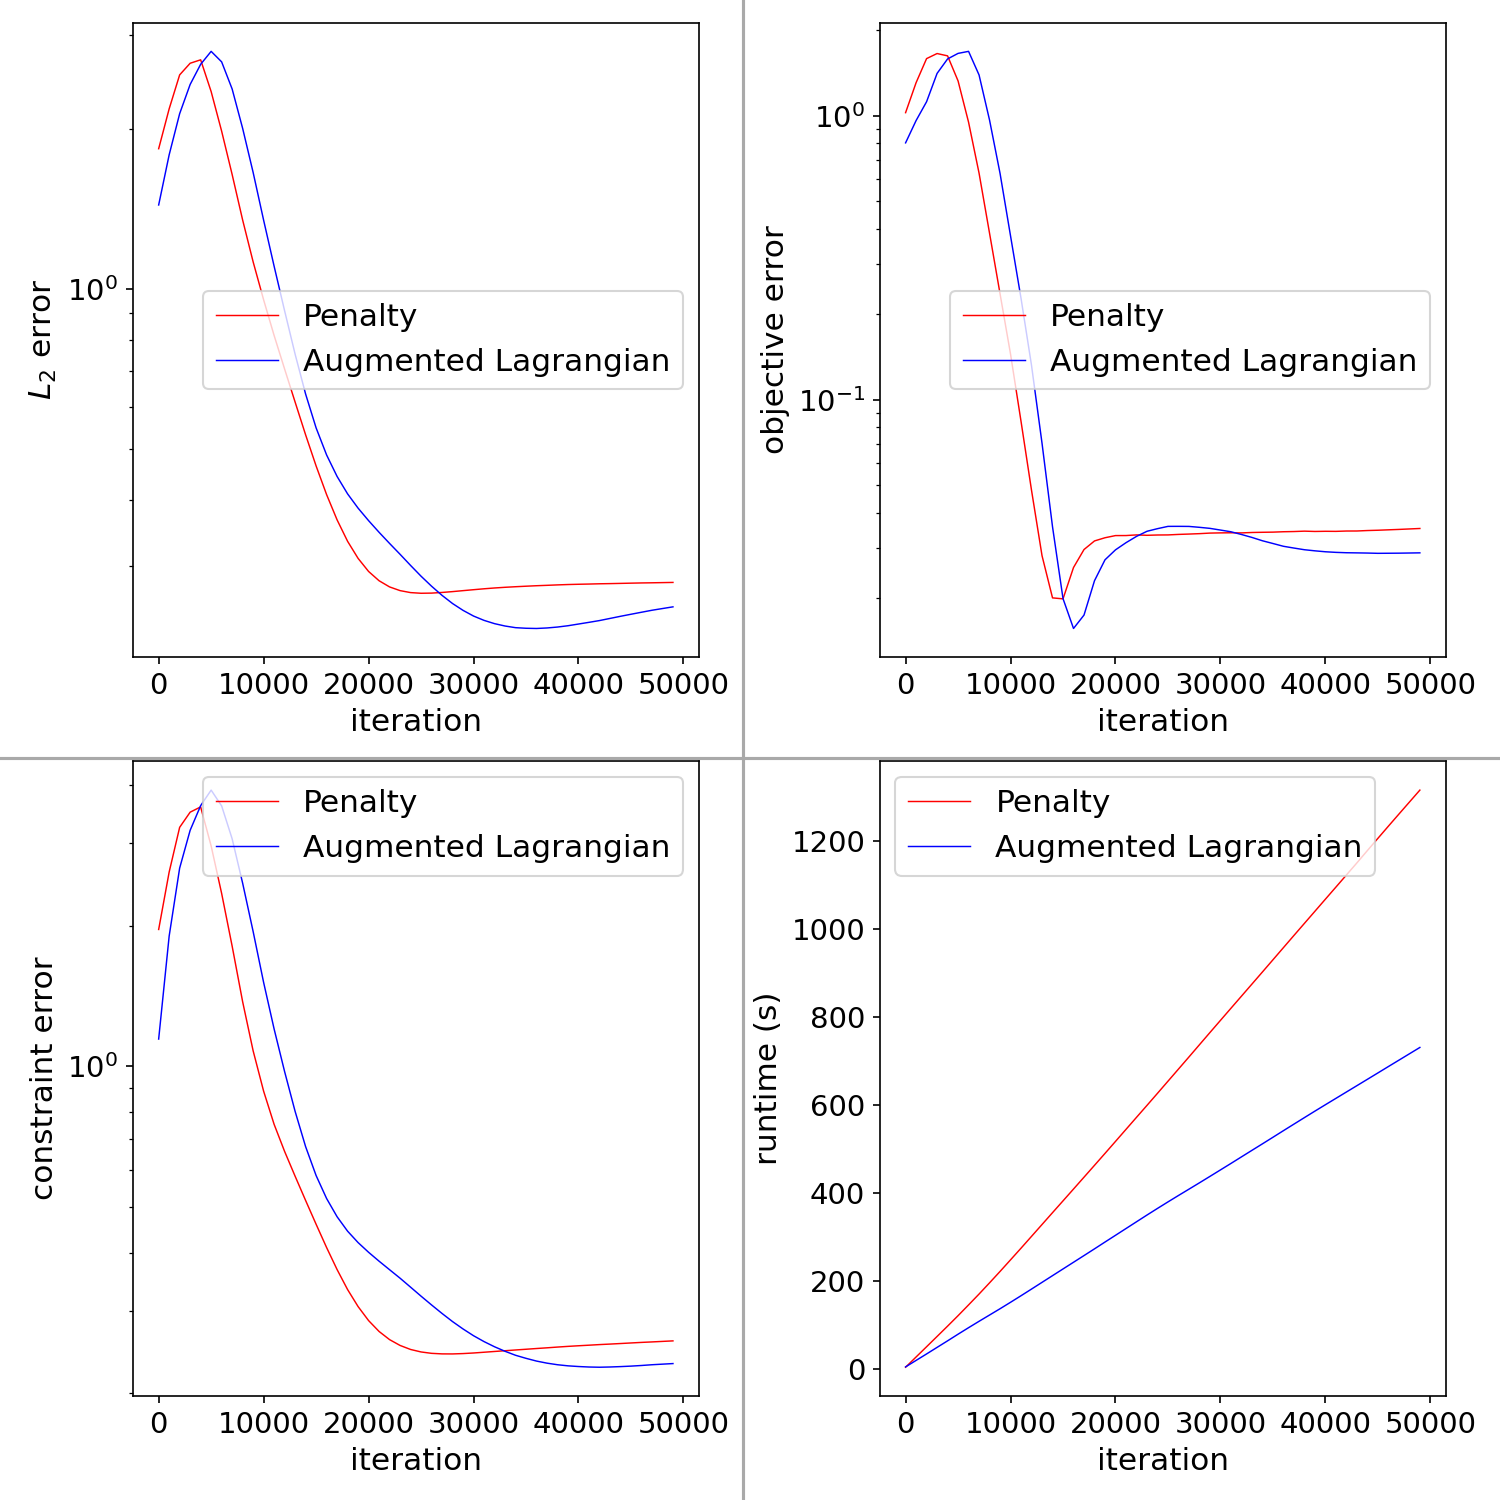

In [109]:
def smooth(y, k):
    y_smooth = savgol_filter(y, 5, k)
    return y_smooth

tick_size = 14 + scale
def plot_errors(filename, last, interval, k):
    fig = plt.figure(figsize=(10, 10))
    ax_l = fig.add_subplot(221)
    ax_o = fig.add_subplot(222)
    ax_c = fig.add_subplot(223)
    ax_m = fig.add_subplot(224)
    # plotting params  
    ax_l.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_l.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_l.set_title('Penalty solution', fontsize=title_size)
    ax_l.set_xlabel('iteration', fontsize=xlabel_size)
    ax_l.set_ylabel(r'$L_2$ error', fontsize=ylabel_size)
    
    ax_o.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_o.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_o.set_title('Augmented Lagrangian solution', fontsize=title_size)
    ax_o.set_xlabel('iteration', fontsize=xlabel_size)
    ax_o.set_ylabel('objective error', fontsize=ylabel_size)

    ax_c.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_c.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_c.set_title('True solution', fontsize=title_size)
    ax_c.set_xlabel('iteration', fontsize=xlabel_size)
    ax_c.set_ylabel('constraint error', fontsize=ylabel_size)

    ax_m.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_m.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_c.set_title('True solution', fontsize=title_size)
    ax_m.set_xlabel('iteration', fontsize=xlabel_size)
    ax_m.set_ylabel('runtime (s)', fontsize=ylabel_size)
    
    df_p = pd.read_csv('../data/Beltrami/train_log.csv')
    df_al = pd.read_csv('../data/Beltrami-al/train_log.csv')

    x = df_p['iteration'].to_numpy()[0:last:interval]
    ax_l.semilogy(x, smooth(df_p['L2-error'].to_numpy()[0:last:interval], k), linewidth=0.7, label='Penalty', c='red')
    ax_l.semilogy(x, smooth(df_al['L2-error'].to_numpy()[0:last:interval], k), linewidth=0.7, label='Augmented Lagrangian', c='blue')
    ax_l.legend(fontsize=legend_size)
    ax_o.semilogy(x, smooth(np.abs(df_p['objective-error'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Penalty', c='red')
    ax_o.semilogy(x, smooth(np.abs(df_al['objective-error'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Augmented Lagrangian', c='blue')
    ax_o.legend(fontsize=legend_size)
    ax_c.semilogy(x, smooth(np.abs(df_p['constraint-error'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Penalty', c='red')
    ax_c.semilogy(x, smooth(np.abs(df_al['constraint-error'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Augmented Lagrangian', c='blue')
    ax_c.legend(fontsize=legend_size)
    ax_m.plot(x, smooth(np.abs(df_p['runtime'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Penalty', c='red')
    ax_m.plot(x, smooth(np.abs(df_al['runtime'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Augmented Lagrangian', c='blue')
    ax_m.legend(fontsize=legend_size)
    l = 0.45
    line = plt.Line2D([l+.045,l+.045],[0.,1], transform=fig.transFigure, color=line_color)
    fig.add_artist(line)
    l = 0.45
    line = plt.Line2D([0.0,1],[l+.045,l+.045], transform=fig.transFigure, color=line_color)
    fig.add_artist(line)
    fig.tight_layout()
    plt.savefig('{}.png'.format(filename), dpi=300)
    plt.show()
    

plot_errors('../plots/Grad-Shafranov-error', last=500, interval=10, k=1)